In [1]:
import pandas as pd
import os
import re
import unicodedata
from rapidfuzz import fuzz, process as fuzzprocess
import numpy as np
import os
import unicodedata
import pandas as pd

In [2]:
_re_non_alnum = re.compile(r"[^0-9a-z]+")
_re_multi_unders = re.compile(r"_+")

def normalizar_texto(texto: str) -> str:
    """Normaliza texto : sin acentos, minúsculas, underscores limpios."""
    if not isinstance(texto, str):
        return texto

    texto = unicodedata.normalize("NFKD", texto)
    texto = "".join(c for c in texto if not unicodedata.combining(c))
    texto = texto.lower()

    texto = _re_non_alnum.sub("_", texto)
    texto = _re_multi_unders.sub("_", texto)
    return texto.strip("_")

In [3]:
def normalize_sheet_name(name):
    """Normaliza y singulariza para evitar 'vehiculos' / 'vehiculo'."""
    norm = normalizar_texto(name)
    # singularización simple
    if norm.endswith("es") and len(norm) > 3:
        norm = norm[:-2]
    elif norm.endswith("s") and len(norm) > 2:
        norm = norm[:-1]
    return norm

In [4]:
# 

root_excels = r"C:\\Users\\hiros\\Desktop\\CMS-PRUEBA-TECNICA\\descargas"

MESES = {
    "enero": 1, "febrero": 2, "marzo": 3, "abril": 4,
    "mayo": 5, "junio": 6, "julio": 7, "agosto": 8,
    "septiembre": 9, "octubre": 10, "noviembre": 11, "diciembre": 12
}
años = ['2025','2024','2023','2022','2021','2020','2019','2018','2017','2016','2015','2014','2013','2012','2011','2010']


def extraer_mes_nomb_excel(nombre_archivo):
    # quitar extensión
    nombre = os.path.splitext(nombre_archivo)[0].lower()

    # separar por espacios, guiones, underscores, etc.
    partes = re.split(r"[ _\-]+", nombre)

    # buscar coincidencia exacta
    for parte in partes:
        if parte in MESES:
            return parte  # retorna el nombre del mes encontrado

    # búsqueda más flexible: " - diciembre 2012"
    for mes in MESES:
        if mes in nombre:
            return mes

    return None


def extraer_año(nombre_archivo):
    
    # quitar extensión
    nombre = os.path.splitext(nombre_archivo)[0].lower()

    # separar por espacios, guiones, underscores, etc.
    partes = re.split(r"[ _\-]+", nombre)

    # buscar coincidencia exacta
    for parte in partes:
        if parte in años:
            return parte  # retorna el año encontrado

    # búsqueda más flexible: " - diciembre 2012"
    for año in años:
        if año in nombre:
            return año

    return None

In [5]:
column_groups = {
    "tipo_servicio": [
        "tipo_servicio", "tiposervicio", "tipo_serviccio",
        "tipo_servcio", "tipo_servicio_", "tipo_servicio_1",
        "tipo_servicio1"
    ],
    "fecha_ingreso_rnt": [
        "fecha_ingreso_rnt", "fecha_ingreso_rntt", "fecha_ingreso_rnttt",
        "fecha_ingreso_rnt_1", "fecha_ingreso_rnt1",
        "fecha_ingreso_rnt_", "fecha_ingreso_rnt_"
    ],
    "combustible": [
        "combustible", "tipo_combustible", "tipo_combustible_",
        "tipo_combustible1"
    ],
    "fecha_ingreso": [
        "fecha_ingreso", "fecha_ingreso_servicio", "fecha_ingreso1"
    ],
    "ano_fabricacion": [
        "ano_fabricacion", "anofabricacion", "año_fabricacion",
        "ano_fabricacion_", "ano_fabricacion1"
    ]
}


In [6]:
def unificar_columnas(df, groups):
    """
    Unifica columnas variantes en una sola columna estándar.
    
    Args:
        df (pd.DataFrame): DataFrame a procesar
        groups (dict): diccionario donde keys = nombre final, values = listas de variantes
    Returns:
        pd.DataFrame: DataFrame con columnas unificadas
    """
    df = df.copy()

    for final_col, variantes in groups.items():
        # Detectar qué columnas del DataFrame existen entre las variantes
        existentes = [c for c in variantes if c in df.columns]
        if not existentes:
            continue

        print(f"\n🛠 Unificando columna: {final_col}")
        print(f"Columnas detectadas: {existentes}")

        # Log: nulos antes
        for c in existentes:
            print(f"   - {c}: nulos = {df[c].isna().sum()} | no nulos = {df[c].notna().sum()}")

        # Tomar la primera columna no nula de izquierda a derecha
        df[final_col] = df[existentes].bfill(axis=1).iloc[:, 0]

        # Log: nulos después
        print(f"➡ Resultado {final_col}: nulos = {df[final_col].isna().sum()} | no nulos = {df[final_col].notna().sum()}")

        # Eliminar columnas usadas excepto la final
        to_drop = [c for c in existentes if c != final_col]
        df = df.drop(columns=to_drop)

    return df


In [7]:
def es_hoja_vehiculo(sheet_name: str) -> bool:
    norm = normalize_sheet_name(sheet_name)  # e.g. "Servicios" → "servicios"
    tokens = norm.split("_")

    # 1) Token empieza con "veh" → MUY seguro
    for t in tokens:
        if t.startswith("veh"):
            return True

    # 2) Excluir explícitamente cosas tipo "servicio" / "servicios"
    if any(t.startswith(("serv", "servi", "servic")) for t in tokens):
        return False

    # 3) Fuzzy matching seguro contra "vehiculo"
    score = fuzz.partial_ratio(norm, "vehiculo")
    if score >= 75:
        return True

    # 4) Fuzzy por token con longitud mínima (evita match con "ser")
    for t in tokens:
        if len(t) >= 3:
            if fuzz.partial_ratio(t, "veh") >= 90:
                return True

    return False


In [8]:
def leer_excels_vehiculos(root_path, column_groups):
    """
    Lee todos los Excel de la carpeta raíz, detecta hojas tipo 'vehiculo',
    normaliza y unifica columnas según el diccionario proporcionado, con debug de nombres.

    Args:
        root_path (str): Ruta raíz donde están los años con Excel
        column_groups (dict): Diccionario para unificar columnas

    Returns:
        pd.DataFrame: DataFrame concatenado de todos los Excel procesados
    """
    todos = []

    for year_folder in os.listdir(root_path):
        ruta_año = os.path.join(root_path, year_folder)
        if not os.path.isdir(ruta_año):
            continue

        for archivo in os.listdir(ruta_año):
            if not archivo.lower().endswith((".xlsx", ".xls", ".xlsm")):
                continue

            ruta_file = os.path.join(ruta_año, archivo)

            año_det = extraer_año(archivo)
            mes_det = extraer_mes_nomb_excel(archivo)

            try:
                excel = pd.ExcelFile(ruta_file)
            except Exception as e:
                print(f"❌ Error abriendo {archivo}: {e}")
                continue

            encontro_hoja = False

            for hoja in excel.sheet_names:
                if es_hoja_vehiculo(hoja):
                    print(f"\n=========================")
                    print(f"✔ LEYENDO ARCHIVO: {archivo}")
                    print(f"✔ Hoja detectada: {hoja}")
                    print(f"=========================")

                    try:
                        # Leer la hoja
                        df = pd.read_excel(ruta_file, sheet_name=hoja)

                        # Debug: nombres originales
                        print("\n🔹 Columnas originales:")
                        print(list(df.columns))

                        # 1️⃣ Normalizar nombres de columna
                        df.columns = [normalizar_texto(c) for c in df.columns]

                        # Debug: nombres después de normalizar
                        print("\n🔹 Columnas normalizadas:")
                        print(list(df.columns))

                        # 2️⃣ Unificar columnas según el diccionario
                        df = unificar_columnas(df, column_groups)

                        # Debug: nombres después de unificar
                        print("\n🔹 Columnas después de unificar:")
                        print(list(df.columns))

                        # LOG: nulos por columna después de unificar
                        print("\n📌 NULOS DESPUÉS DE UNIFICAR COLUMNAS:")
                        print(df.isna().sum().sort_values(ascending=False))

                        # 3️⃣ Agregar info extra
                        df["año_archivo"] = año_det
                        df["mes_archivo"] = mes_det
                        df["archivo"] = archivo
                        df["hoja"] = hoja

                        # 4️⃣ Guardar en la lista
                        todos.append(df)
                        encontro_hoja = True

                    except Exception as e:
                        print(f"❌ Error leyendo hoja {hoja} en {archivo}: {e}")
                    continue

            if not encontro_hoja:
                print(f"\n⚠ No encontré hoja tipo 'vehiculo' en: {archivo}")
                print("Hojas disponibles:")
                for i, h in enumerate(excel.sheet_names):
                    print(f"[{i}] {h}")
                continue

    if todos:
        return pd.concat(todos, ignore_index=True)
    return pd.DataFrame()




In [9]:
df_vehiculos = leer_excels_vehiculos(root_excels, column_groups)
df_vehiculos 



✔ LEYENDO ARCHIVO: Base de Datos de Transporte Público - Abril 2021.xlsx
✔ Hoja detectada: Vehículos

🔹 Columnas originales:
['REGION', 'FOLIO', 'TIPO_SERVICIO', 'PPU', 'FECHA_INGRESO_RNT', 'MARCA', 'MODELO', 'ANO_FABRICACION', 'CAPACIDAD']

🔹 Columnas normalizadas:
['region', 'folio', 'tipo_servicio', 'ppu', 'fecha_ingreso_rnt', 'marca', 'modelo', 'ano_fabricacion', 'capacidad']

🛠 Unificando columna: tipo_servicio
Columnas detectadas: ['tipo_servicio']
   - tipo_servicio: nulos = 0 | no nulos = 136031
➡ Resultado tipo_servicio: nulos = 0 | no nulos = 136031

🛠 Unificando columna: fecha_ingreso_rnt
Columnas detectadas: ['fecha_ingreso_rnt']
   - fecha_ingreso_rnt: nulos = 0 | no nulos = 136031
➡ Resultado fecha_ingreso_rnt: nulos = 0 | no nulos = 136031

🛠 Unificando columna: ano_fabricacion
Columnas detectadas: ['ano_fabricacion']
   - ano_fabricacion: nulos = 0 | no nulos = 136031
➡ Resultado ano_fabricacion: nulos = 0 | no nulos = 136031

🔹 Columnas después de unificar:
['region',

,region,folio,tipo_servicio,ppu,fecha_ingreso_rnt,marca,modelo,ano_fabricacion,capacidad,año_archivo,mes_archivo,archivo,hoja,fecha_ingreso,combustible,linea
0,1.0,10,TAXI COLECTIVO RURAL,RW2882,2007-06-26,HYUNDAI,ACCENT GL 1.5,2007.0,4.0,2021,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN
1,1.0,12,TAXI COLECTIVO RURAL,BCRH67,2019-10-07,HYUNDAI,ACCENT 1.6,2015.0,NaN,2021,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN
2,1.0,18,TAXI COLECTIVO RURAL,DWCY37,2012-05-15,HYUNDAI,ACCENT RB GL 1.6,2012.0,4.0,2021,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN
3,1.0,19,TAXI COLECTIVO RURAL,DGFX88,2011-08-30,HYUNDAI,ACCENT RB GL 1.6,2011.0,4.0,2021,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN
4,1.0,24,TAXI COLECTIVO RURAL,FPCP93,2013-05-03,HYUNDAI,ACCENT RB GL 1.6,2013.0,4.0,2021,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10480787,16.0,500700,BUS RURAL CORRIENTE,DKWJ44,2013-06-03-15.58.03.000000,SCANIA,K380B,2012.0,44.0,2019,diciembre,Base de Datos de Transporte Público - Diciembr...,Vehiculos,NaN,NaN,NaN
10480788,16.0,500936,BUS RURAL CORRIENTE,BXDK27,2015-11-10-17.26.01.000000,MERCEDES BENZ,0500 RS,2009.0,NaN,2019,diciembre,Base de Datos de Transporte Público - Diciembr...,Vehiculos,NaN,NaN,NaN
10480789,16.0,500825,BUS RURAL CORRIENTE,KXBT57,2018-11-09-00.00.00.000000,MERCEDES BENZ,OF 1724,2019.0,46.0,2019,diciembre,Base de Datos de Transporte Público - Diciembr...,Vehiculos,NaN,NaN,NaN
10480790,16.0,400080,BUS URBANO CORRIENTE,WK7479,2007-08-10-12.00.00.000000,MERCEDES BENZ,LO 914 42,2007.0,NaN,2019,diciembre,Base de Datos de Transporte Público - Diciembr...,Vehiculos,NaN,NaN,NaN


<Axes: >

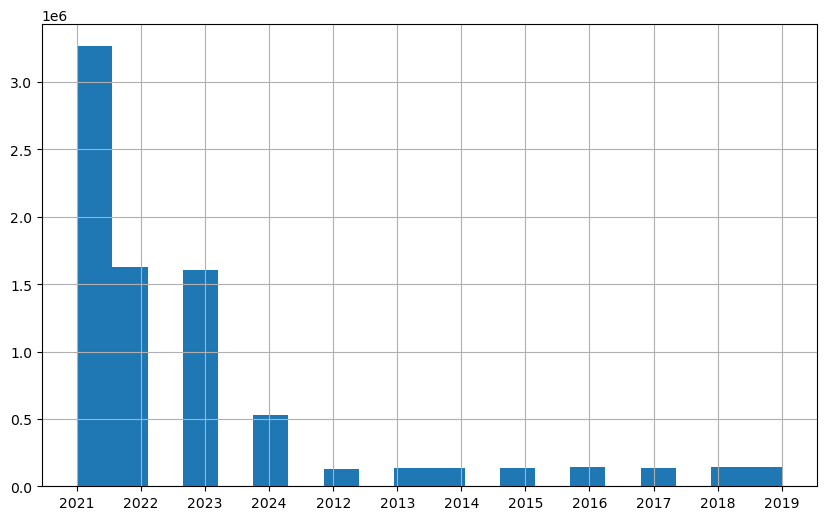

In [13]:
# grafico de valores nulos en combustible por año_archivo
# graficar los años en los que hay valores nulos en combustible_final (histplot)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
df_vehiculos[df_vehiculos['combustible'].isnull()]['año_archivo'].hist(bins=20)


In [15]:
df_vehiculos

,region,folio,tipo_servicio,ppu,fecha_ingreso_rnt,marca,modelo,ano_fabricacion,capacidad,año_archivo,mes_archivo,archivo,hoja,fecha_ingreso,combustible,linea
0,1.0,10,TAXI COLECTIVO RURAL,RW2882,2007-06-26,HYUNDAI,ACCENT GL 1.5,2007.0,4.0,2021,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN
1,1.0,12,TAXI COLECTIVO RURAL,BCRH67,2019-10-07,HYUNDAI,ACCENT 1.6,2015.0,NaN,2021,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN
2,1.0,18,TAXI COLECTIVO RURAL,DWCY37,2012-05-15,HYUNDAI,ACCENT RB GL 1.6,2012.0,4.0,2021,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN
3,1.0,19,TAXI COLECTIVO RURAL,DGFX88,2011-08-30,HYUNDAI,ACCENT RB GL 1.6,2011.0,4.0,2021,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN
4,1.0,24,TAXI COLECTIVO RURAL,FPCP93,2013-05-03,HYUNDAI,ACCENT RB GL 1.6,2013.0,4.0,2021,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10480787,16.0,500700,BUS RURAL CORRIENTE,DKWJ44,2013-06-03-15.58.03.000000,SCANIA,K380B,2012.0,44.0,2019,diciembre,Base de Datos de Transporte Público - Diciembr...,Vehiculos,NaN,NaN,NaN
10480788,16.0,500936,BUS RURAL CORRIENTE,BXDK27,2015-11-10-17.26.01.000000,MERCEDES BENZ,0500 RS,2009.0,NaN,2019,diciembre,Base de Datos de Transporte Público - Diciembr...,Vehiculos,NaN,NaN,NaN
10480789,16.0,500825,BUS RURAL CORRIENTE,KXBT57,2018-11-09-00.00.00.000000,MERCEDES BENZ,OF 1724,2019.0,46.0,2019,diciembre,Base de Datos de Transporte Público - Diciembr...,Vehiculos,NaN,NaN,NaN
10480790,16.0,400080,BUS URBANO CORRIENTE,WK7479,2007-08-10-12.00.00.000000,MERCEDES BENZ,LO 914 42,2007.0,NaN,2019,diciembre,Base de Datos de Transporte Público - Diciembr...,Vehiculos,NaN,NaN,NaN


In [14]:
df_vehiculos.to_csv("C:\\Users\\hiros\\Desktop\\CMS-PRUEBA-TECNICA\\Normalizar datos\\vehiculos_extraidos.csv")